In [123]:
# check device
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# check GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2166522620480219996
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401616449
locality {
  bus_id: 1
}
incarnation: 2276482877652127720
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7241117229
locality {
  bus_id: 1
}
incarnation: 17961274860879617549
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]
Num GPUs Available:  2


In [124]:
# Use GPU for tensorflow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [125]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for all GPUs")
    except RuntimeError as e:
        print(e)


Memory growth set for all GPUs


# 1. Setup and Preprocessing Functions

In [126]:
#!pip uninstall tensorflow --yes
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install --upgrade pip


In [127]:
# enable cuda
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [128]:
import os
import time
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
import numpy as np

In [129]:
# Function to load and preprocess the image
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess and display/save image
def deprocess_image(image):
    img = image.copy()
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Content and Style Loss
def content_loss(base_content, target):
    total_loss = 0
    for name in base_content.keys():
        total_loss += tf.reduce_mean(tf.square(base_content[name] - target[name]))
    return total_loss

def style_loss(base_style, gram_target):
    total_loss = 0
    for name in base_style.keys():
        # Debugging: Print the shape of tensors before passing to gram_matrix
        #print(f"Shape of base_style[{name}]:", base_style[name].shape)
        #print(f"Shape of gram_target[{name}]:", gram_target[name].shape)

        # Ensure the tensor is 4D
        style_output = base_style[name]
        if len(style_output.shape) == 3:
            style_output = tf.expand_dims(style_output, axis=-1)

        total_loss += tf.reduce_mean(tf.square(gram_matrix(style_output) - gram_target[name]))
    return total_loss

def gram_matrix(input_tensor):
    # Debugging: Print the shape of the tensor
    #print("Shape of input tensor:", input_tensor.shape)

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# 2. Define the Custom Model

Enhanced Custom Model Architecture

Increasing Model Depth: More convolutional layers can help the model learn more complex features. However, deeper models also require more computational resources and can be more prone to overfitting.

Incorporating Batch Normalization: This can help in stabilizing and speeding up the training process. It normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

Using Advanced Activation Functions: Advanced activation functions like LeakyReLU or ELU might offer better performance in some cases compared to the standard ReLU.

Adding Residual Connections: Residual connections can help in training deeper networks by allowing gradients to flow through the network more effectively.

Upsampling and Downsampling: For capturing both high-level content and style details, a combination of downsampling (using pooling layers) and upsampling (using transpose convolutional layers) can be effective.

Adjusting Filter Sizes and Numbers: Experiment with different filter sizes and numbers of filters. More filters can capture more detailed features but also increase computational complexity.

Regularization Techniques: Implement dropout or L2 regularization in your layers to prevent overfitting, especially if you have a deep network or a small dataset.

In [130]:
def create_custom_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # # Classification block
    # model.add(Flatten())
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dense(1000, activation='softmax')) # 1000 for ImageNet

    return model


custom_model = create_custom_model()
custom_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_92 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_94 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [131]:
class CustomStyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(CustomStyleContentModel, self).__init__()
        self.custom_model = create_custom_model()  # Use our custom model
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.custom_model(preprocessed_input)

        style_outputs, content_outputs = [], []
        for i, layer_output in enumerate(outputs):
            if i in self.style_layers:
                style_outputs.append(layer_output)
            if i in self.content_layers:
                content_outputs.append(layer_output)

        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        return {'content': content_dict, 'style': style_dict}


# 3. Tuning the Model 
(Cannot be Done with limited training data and computational resource)

# 4. List Images in Directories

In [132]:
# Paths to your images
content_dir = r'C:\Users\skyxt\OneDrive - The University of Chicago\ADSP 32023 Advanaced Computer Vision with Deep Learning\Final Project\Google Scraped Image Dataset\images\images\food and drinks'
style_dir = r'C:\Users\skyxt\OneDrive - The University of Chicago\ADSP 32023 Advanaced Computer Vision with Deep Learning\Final Project\Best Artworks of All Time\images\images\Pablo_Picasso'

content_images = [os.path.join(content_dir, f) for f in os.listdir(content_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
style_images = [os.path.join(style_dir, f) for f in os.listdir(style_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [143]:
content_path

'C:\\Users\\skyxt\\OneDrive - The University of Chicago\\ADSP 32023 Advanaced Computer Vision with Deep Learning\\Final Project\\Google Scraped Image Dataset\\images\\images\\food and drinks\\0 (3).jpg'

In [144]:
style_path

'C:\\Users\\skyxt\\OneDrive - The University of Chicago\\ADSP 32023 Advanaced Computer Vision with Deep Learning\\Final Project\\Best Artworks of All Time\\images\\images\\Pablo_Picasso\\Pablo_Picasso_316.jpg'

In [133]:
content_path = content_images[1]
style_path = style_images[241]

content_images = content_images[1]
style_images = style_images[241]

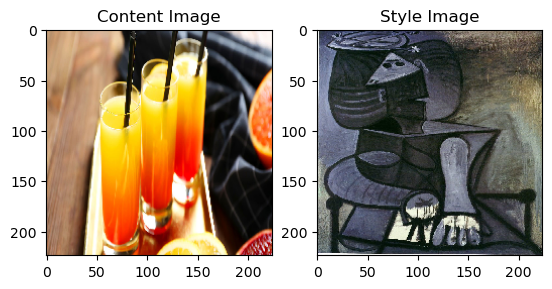

In [134]:
# After loading and preprocessing
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# Deprocess the images
content_image_deprocessed = deprocess_image(content_image)
style_image_deprocessed = deprocess_image(style_image)

# Display the deprocessed images
plt.subplot(1, 2, 1)
plt.imshow(content_image_deprocessed)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image_deprocessed)
plt.title("Style Image")
plt.show()


In [135]:
# Function to create a unique filename for each generated image
def create_filename(content_path, style_path, output_dir):
    content_name = os.path.basename(content_path).split('.')[0]
    style_name = os.path.basename(style_path).split('.')[0]
    return os.path.join(output_dir, f"{content_name}_styled_with_{style_name}.png")

# Output directory for saved images
output_dir = r'C:\Users\skyxt\OneDrive - The University of Chicago\ADSP 32023 Advanaced Computer Vision with Deep Learning\Final Project\Transferred Graphs'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 6. Loop Through Content and Style Images

In [136]:
# # Define layers
#  # Define according to your requirements
# style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
#  # Define according to your requirements
# content_layers = ['block5_conv2']


# # Initialize the model with the defined style and content layers
# extractor = StyleContentModel(style_layers, content_layers)

In [137]:
# Define weights for content and style loss
content_weight = 1e3
style_weight = 1e-2

# Define layers (using indices)
style_layers = [0, 2]  # Modify as needed
content_layers = [4]  # Modify as needed

# Initialize the model with the defined style and content layers
extractor = CustomStyleContentModel(style_layers, content_layers)

In [139]:
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

        # Extract style and content features from content and style images
style_outputs = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


style_targets = {}
for name, output in style_outputs.items():
            if len(output.shape) == 3:  # Check and reshape if necessary
                output = tf.expand_dims(output, axis=-1)
            style_targets[name] = gram_matrix(output)

        # Initialize the generated image to the content image
generated_image = tf.Variable(content_image)

        # Define optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        # Define number of iterations
epochs = 10  # Adjust as needed
steps_per_epoch = 100  # Adjust as needed

        # Start the style transfer process
for n in range(epochs):
            for m in range(steps_per_epoch):
                with tf.GradientTape() as tape:
                    # Extract features of the generated image
                    generated_outputs = extractor(generated_image)
                    
                    # Compute losses
                    loss_c = content_loss(generated_outputs['content'], content_targets)
                    loss_s = style_loss(generated_outputs['style'], style_targets)
                    loss = loss_c * content_weight + loss_s * style_weight

                # Compute gradients and apply them
                grad = tape.gradient(loss, generated_image)
                opt.apply_gradients([(grad, generated_image)])
                generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

        # Deprocess and save the final image
final_img = deprocess_image(generated_image.numpy())
filename = create_filename(content_path, style_path, output_dir)
plt.imsave(filename, final_img)

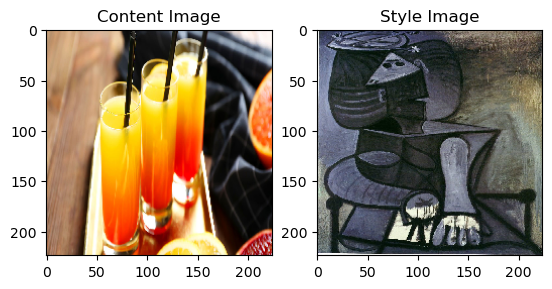

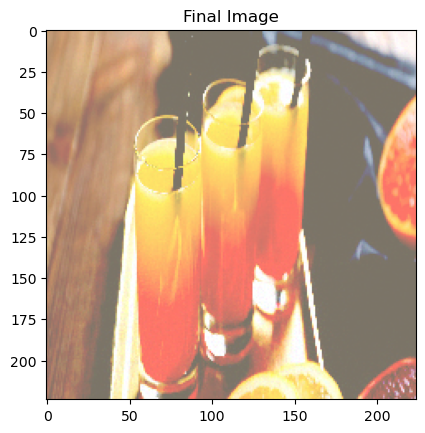

In [140]:
# After loading and preprocessing
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# Deprocess the images
content_image_deprocessed = deprocess_image(content_image)
style_image_deprocessed = deprocess_image(style_image)

# Display the deprocessed images
plt.subplot(1, 2, 1)
plt.imshow(content_image_deprocessed)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image_deprocessed)
plt.title("Style Image")
plt.show()


# Display the final image
plt.imshow(final_img)
plt.title("Final Image")
plt.show()

# Use VGG

## Final Model Description
The final model for neural style transfer is based on the VGG19 architecture, a convolutional neural network pre-trained on the ImageNet dataset. It's used to extract content and style features from images. The model is modified to output specific layers that are crucial for capturing the style and content of images. The style transfer process involves taking two images—a content image and a style reference image—and blending them together so that the output image retains the content of the former but is stylized like the latter.